# Predicting Company Bankruptcy using Liability Financial Metrics

## Introduction
Business failures, or "bankruptcies" as they may be more commonly refered to as, are a very real and unfortunate part of society.  They can occur through the natural course of progression (such as smartphone cameras replacing the non-professional dedicated camera market), or be exacerbated through exogenous shocks (such as the dot-com bubble of 2001, or the 2007 financial crisis).  In this analysis, we will try to determine if we can predict the looming bankruptcy of a company based on a variety of their fundamental financial metrics.  Specifically, we will be looking at various debt and/or liability ratios in conducting our analysis.

The dataset we will be using is the Taiwanese Bankruptcy Prediction dataset, which comes from the Taiwan Economic Journal (TEJ).  Founded in April 1990, the TEJ has specialized in providing all required and value-added information for fundamental analysis of the securities financial market[1].  Between the years 1999 and 2009, the TEJ recorded 220 instances of bankruptcy within the 6,819 instances of companies and their financial metrics they analysed[2].  Company bankruptcy was defined based ont he business rules of the Taiwan Stock Exchange.

The dataset includes 95 columns of financial metrics, and a 96th column for a bankruptcy flag (yes / no).


[1] https://www.tejwin.com/en/about/

[2] 
Lyon,Robert. (2017). HTRU2. UCI Machine Learning Repository. https://doi.org/10.24432/C5DK6R.

## Preliminary Data Analysis

We will start off by reading necessary libraries:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(janitor)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Then we will read and tidy data.

To read, we will need to:
1) download the zip file from its source [2] above
2) specify where to save the zip file
3) unzip the file to our desired location
   
In the process of tidying, we will need to:
1) clean the headers of our data as numerous of them have spaces and/or invalid characters (such as "?" or "/")
2) change our classification column, "bankruptcy", to a factor, and rename the 1 and 0 by their respective human definitions
3) select the columns necessary to our analysis, namely: bankrupt, columns containing the word "debt", and columns containing any form of the word "liability"

In [12]:
#get file, which is stored as a .zip
url <- "https://archive.ics.uci.edu/static/public/572/taiwanese+bankruptcy+prediction.zip"
data_directory <- "data/"
zip_file_name <- "data.zip"
download.file(url, paste(data_directory, zip_file_name, sep=""), mode = "wb")

#unzip the zipfile
unzip(paste(data_directory, zip_file_name, sep=""),exdir=data_directory)

taiwan_data <- read_csv("data/data.csv") |>
               clean_names(replace = c('/' = " to ", '%' = "percent")) #the headers have numerous spaces and/or invalid characters

taiwan_tidy <- taiwan_data |>
                mutate(bankrupt = fct_recode(factor(bankrupt), "Bankrupt" = '1', "Not Bankrupt" = '0'), debt_ratio_percent = debt_ratio_percent * 100) |> #change numerical values to factors/classifications.
                select(bankrupt, contains("debt"), contains("liabilit")) |>  #select 1) classification column (bankrupt), 2) columns containing "Debt", and 3) columns containing any form of liability
                select(!c(interest_bearing_debt_interest_rate, liability_assets_flag))

taiwan_tidy

Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): Bankrupt?, ROA(C) before interest and depreciation before interest...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


bankrupt,total_debt_to_total_net_worth,debt_ratio_percent,contingent_liabilities_to_net_worth,quick_assets_to_current_liability,cash_to_current_liability,current_liability_to_assets,operating_funds_to_liability,inventory_to_current_liability,current_liabilities_to_liability,current_liabilities_to_equity,long_term_liability_to_current_assets,current_liability_to_liability,current_liability_to_equity,equity_to_long_term_liability,cash_flow_to_liability,current_liability_to_current_assets,liability_to_equity,equity_to_liability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bankrupt,0.02126592,20.75763,0.006478502,0.001996771,1.47336e-04,0.14730845,0.3340152,0.001035990,0.6762692,0.3390770,0.025592368,0.6762692,0.3390770,0.1265495,0.4586091,0.11825048,0.2902019,0.01646874
Bankrupt,0.01250239,17.11763,0.005835039,0.004136030,1.38391e-03,0.05696283,0.3411060,0.005209682,0.3085886,0.3297401,0.023946819,0.3085886,0.3297401,0.1209161,0.4590011,0.04777528,0.2838460,0.02079431
Bankrupt,0.02124769,20.75158,0.006561982,0.006302481,5.34000e+09,0.09816206,0.3367315,0.013878786,0.4460275,0.3347769,0.003715116,0.4460275,0.3347769,0.1179223,0.4592540,0.02534649,0.2901885,0.01647411
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Not Bankrupt,0.0013915866,3.893944,0.005365848,0.035531293,0.088212480,0.02441366,0.3588474,0.007809807,0.5539642,0.3269206,0.0e+00,0.5539642,0.3269206,0.1109332,0.4524647,0.007542458,0.2757887,0.09764874
Not Bankrupt,0.0038163762,8.697887,0.007067734,0.007753306,0.007133218,0.08319943,0.3802508,0.013333639,0.8932409,0.3292936,3.2e+09,0.8932409,0.3292936,0.1109574,0.4713133,0.022916427,0.2775472,0.04400945
Not Bankrupt,0.0004614304,1.414880,0.006368212,0.051480515,0.066673545,0.01851735,0.2395847,0.000000000,1.0000000,0.3266903,0.0e+00,1.0000000,0.3266903,0.1109332,0.4832848,0.005579107,0.2751141,0.23390224


Following a bit of data tidying, we will separate our data into respective training and testing groups.  As there are only 220 instances of bankruptcy in the dataset of 6,819 observations (and it is also the column we are trying to predict), we will select bankrupt as our strata.

In [3]:
taiwan_split <- initial_split(taiwan_tidy, prop = 0.75, strata = bankrupt)
taiwan_training <- training(taiwan_split)
taiwan_testing <- testing(taiwan_split)

Below we present an initial data summary using training data, noting the count of Bankrupt vs Not Bankrupt against a widely-recognized financial metric, the debt ratio, presented as an average for each of Bankrupt and Not Bankrupt.  Debt ratio is defined as (total debt / total assets):

In [4]:
taiwan_training_count_and_debt_summary <- taiwan_training |>
                                          group_by(bankrupt) |>
                                          summarize(Observations = n(), Average_Debt_Ratio_Percent = mean(debt_ratio_percent))

taiwan_training_count_and_debt_summary

bankrupt,Observations,Average_Debt_Ratio_Percent
<fct>,<int>,<dbl>
Not Bankrupt,4952,11.04660
Bankrupt,162,18.84189


In the following graph, we visualize this average debt ratio %

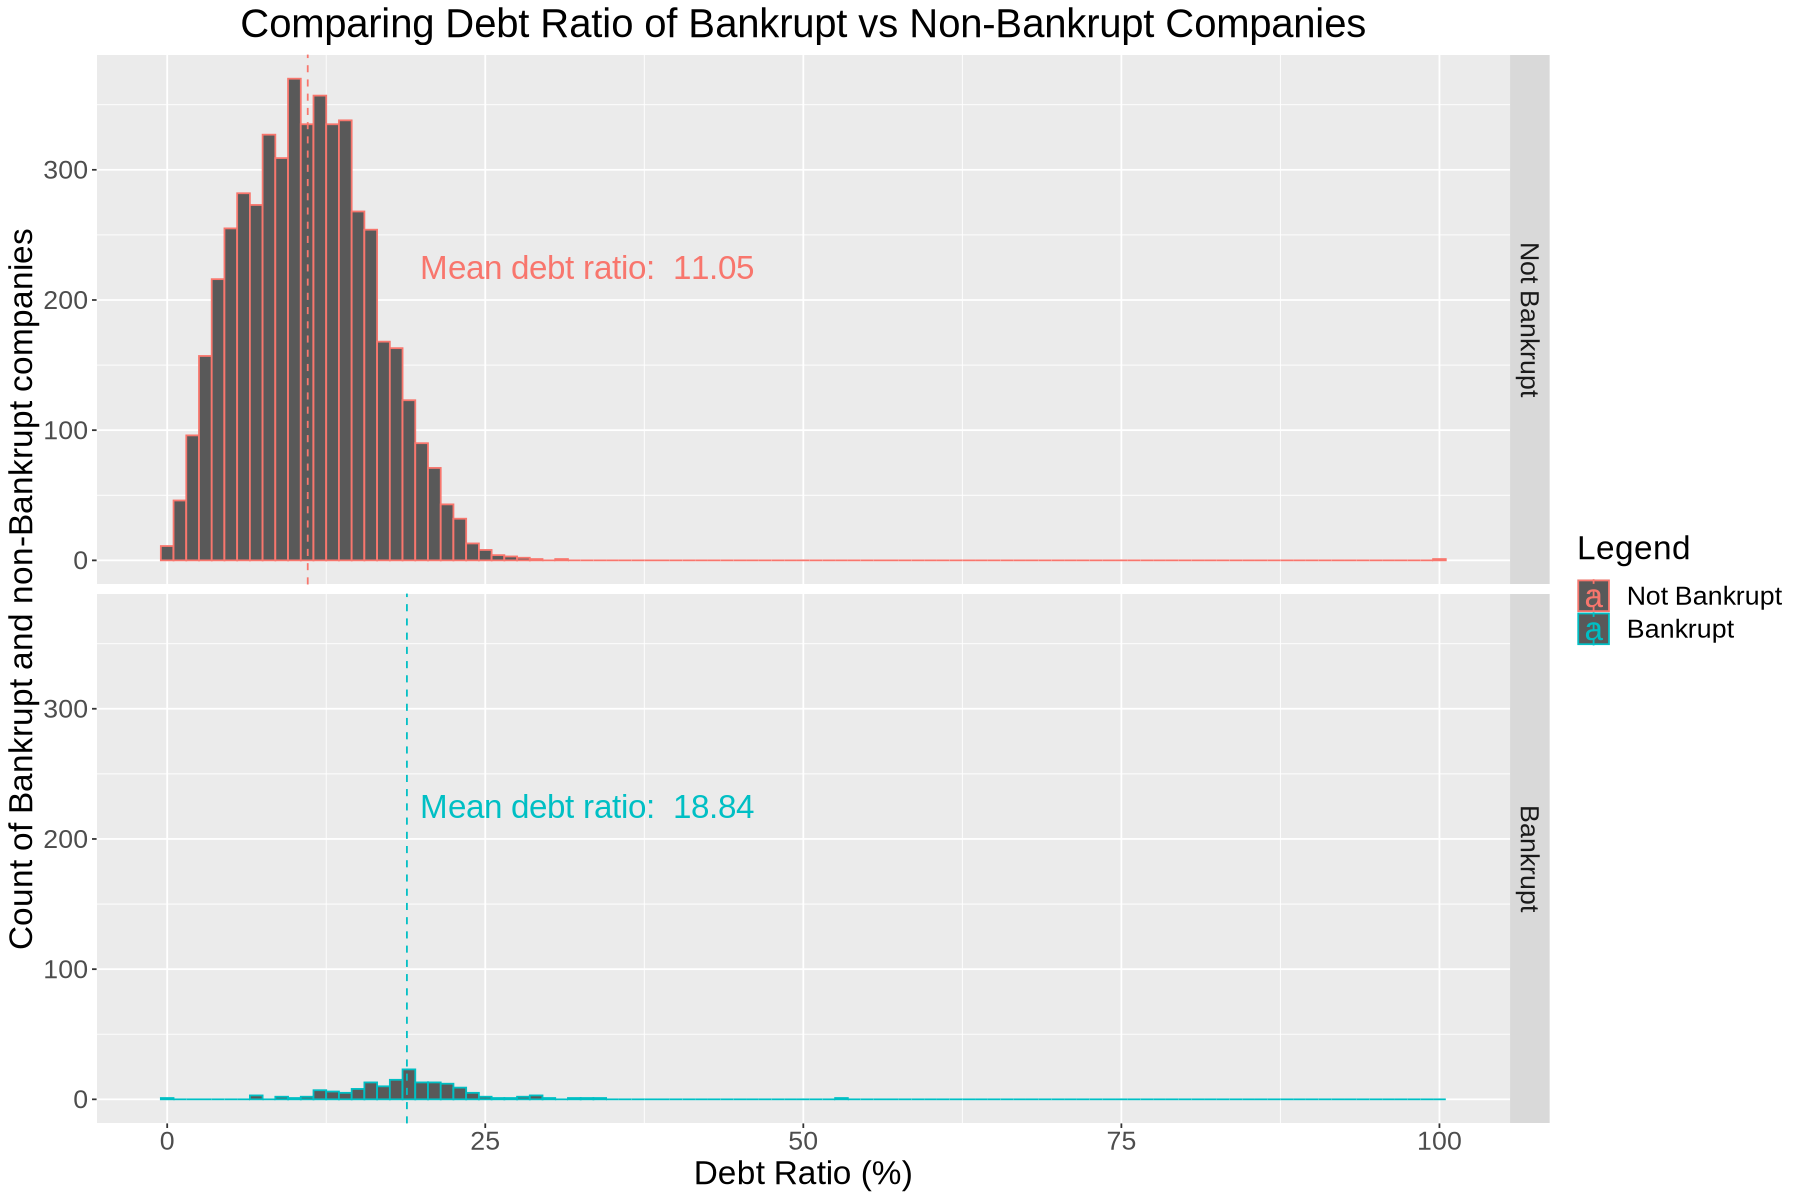

In [5]:
options(repr.plot.width = 15, repr.plot.height = 10)

#annotations <- data.frame(x = c(Average_Debt_Ratio_Percent),  y = c(300),  label = c("Mean:")) 

taiwan_training_histogram <- taiwan_training |>
                             ggplot(aes (x = debt_ratio_percent, colour = bankrupt)) +
                             geom_histogram(binwidth = 1, position = "identity") +
                             facet_grid(bankrupt ~.) +
                             geom_vline(data = taiwan_training_count_and_debt_summary, aes(xintercept=Average_Debt_Ratio_Percent, color=bankrupt), linetype="dashed") +
                             labs(x = "Debt Ratio (%)", y = "Count of Bankrupt and non-Bankrupt companies", colour = "Legend", title = "Comparing Debt Ratio of Bankrupt vs Non-Bankrupt Companies") +
                             geom_text(data = taiwan_training_count_and_debt_summary, aes(label = paste("Mean debt ratio: ", round(Average_Debt_Ratio_Percent,2)), x = 33, y = 225), size = 7) +
                             theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5)) 
taiwan_training_histogram

## Methods

In conducting our analysis, we are focusing on financial metrics which include debt and/or liabilities and have narrowed down the data from 96 to 19 columns.  We expect to narrow down the number of columns further as the analysis progresses, as we may determine some of the financial metrics are not relevant to the analysis.

As depicted in the preliminary histogram above, we can visualize our data by comparing the averages of certain metrics for Bankrupt companies vs Not Bankrupt.  In our preliminary analysis, there does indeed appear to be a significant discrepancy between the respective groups' debt ratios whereby Bankrupt experienced a higher level of average debt vs Not-Bankrupt.

## Expected Outcomes and Significance

We expect to find that companies which have higher levels of liabilities and/or higher levels of debt, relative to their assets and/or cash, are more likely to face bankruptcy.

The impacts of these findings could help create future legislation for the maximum allowable debt and/or liabilities for a given level of assets and/or cash.  For instance, during the period of 1999-2009 there were the two major financial crisis as outlined earlier.  If the firms had a better grasp of their obligations, would they have been able to weather the financial crisis storms?

Based on the findings, some questions arise: what should be the maximum allowable limits?  How could these limits be policed or monitored?  Are some industries more susceptable to higher debt and liability levels relative to others (is it appropriate for a tech firm to have the same levels as a grocery store?), and so forth.